In [433]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer

In [434]:
import os
import itertools
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout, Concatenate, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers


In [435]:
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [436]:
import warnings
warnings.filterwarnings("ignore")

In [437]:
full_df_file = "eye_disease_detection_dataset/archive/full_df.csv"
df = pd.read_csv(full_df_file)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [438]:
df.columns
len(df)
len(df[df.duplicated()])

0

In [439]:
df.isnull().sum()

ID                           0
Patient Age                  0
Patient Sex                  0
Left-Fundus                  0
Right-Fundus                 0
Left-Diagnostic Keywords     0
Right-Diagnostic Keywords    0
N                            0
D                            0
G                            0
C                            0
A                            0
H                            0
M                            0
O                            0
filepath                     0
labels                       0
target                       0
filename                     0
dtype: int64

In [440]:
df['Left-Fundus'].nunique()

3358

In [441]:
photo_counts = df['Left-Fundus'].value_counts()

# Filter names that appear more than once
photo_more_than_once = photo_counts[photo_counts > 1].index.tolist()

print(len(photo_more_than_once))

photo_more_than_once[0]

3034


'4784_left.jpg'

In [442]:
df['labels'].value_counts()

labels
['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: count, dtype: int64

In [443]:
# Find inconsistent or contradicting data, where (label and the Disease columns are not matching)
print(len(df[(df['labels'] == "['N']") & (df['N'] != 1)]))
print(len(df[(df['labels'] == "['D']") & (df['D'] != 1)]))
print(len(df[(df['labels'] == "['O']") & (df['O'] != 1)]))
print(len(df[(df['labels'] == "['C']") & (df['C'] != 1)]))
print(len(df[(df['labels'] == "['G']") & (df['G'] != 1)]))
print(len(df[(df['labels'] == "['A']") & (df['A'] != 1)]))
print(len(df[(df['labels'] == "['M']") & (df['M'] != 1)]))
print(len(df[(df['labels'] == "['H']") & (df['H'] != 1)]))

772
0
3
0
0
0
0
0


In [444]:
#updating the label with the disease column 

df.drop(columns=[ 'ID'] , inplace=True)
len(df[df['Patient Age'] == 1])
def update_labels(row):
    
    x = ''
    for col in df.columns:
        if row[col] == 1 and col != 'Patient Age':
            x = x + col
    row['labels'] = x        
    return row

df = df.apply(update_labels, axis=1)
df['labels'].nunique()

37

In [445]:
df['labels'].nunique()

37

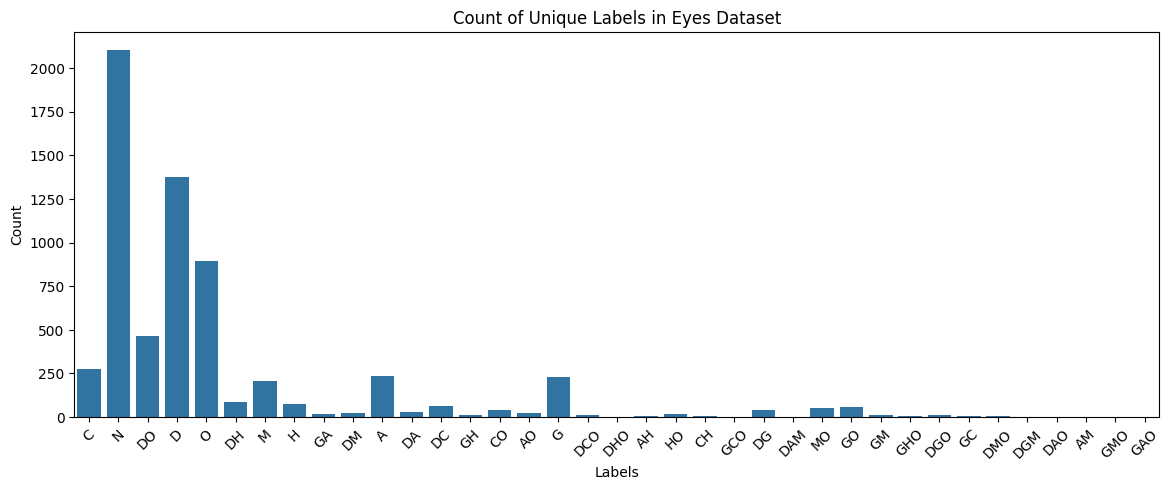

In [446]:
plt.figure(figsize=(14, 5))
sns.countplot(x='labels', data=df , orient='h')
plt.title('Count of Unique Labels in Eyes Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [447]:
df[df['Left-Diagnostic Keywords'] == 'low image quality']

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2547,45,Male,3935_left.jpg,3935_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",3935_right.jpg
2606,71,Male,4007_left.jpg,4007_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4007_right.jpg
2744,48,Male,4169_left.jpg,4169_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4169_right.jpg
2854,51,Male,4290_left.jpg,4290_right.jpg,low image quality,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",4290_right.jpg
2989,62,Female,4442_left.jpg,4442_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4442_right.jpg
2994,50,Male,4448_left.jpg,4448_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4448_right.jpg
3053,67,Male,4522_left.jpg,4522_right.jpg,low image quality,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4522_right.jpg


In [448]:
#df = df.loc[~(df['Left-Diagnostic Keywords'] == 'low image quality')]
#df = df.loc[~(df['Right-Diagnostic Keywords'] == 'low image quality')]
df = df[df['Left-Diagnostic Keywords'] != 'low image quality']
df = df[df['Right-Diagnostic Keywords'] != 'low image quality']


In [449]:
print(len(df[(df['labels'] == "N") & (df['N'] != 1)]))
print(len(df[(df['labels'] == "O") & (df['O'] != 1)]))
df.head()

0
0


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,C,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [450]:
photos_unique = df.drop_duplicates(subset='Left-Fundus', keep='first')
df = photos_unique
df.reset_index(drop=True,inplace=True)
len(df)

3340

In [451]:
df['Left-Diagnostic Keywords'].nunique()

194

In [452]:
df['Right-Diagnostic Keywords'].nunique()

204

In [453]:
df['Left-Diagnostic Keywords'].mode()

0    normal fundus
Name: Left-Diagnostic Keywords, dtype: object

In [454]:
df['Left-Diagnostic Keywords'].value_counts()

Left-Diagnostic Keywords
normal fundus                                                                1433
moderate non proliferative retinopathy                                        359
mild nonproliferative retinopathy                                             217
cataract                                                                      135
pathological myopia                                                           111
                                                                             ... 
epiretinal membrane，epiretinal membrane，lens dust                               1
moderate non proliferative retinopathy，myelinated nerve fibers，laser spot       1
glaucoma，mild nonproliferative retinopathy，macular pigmentation disorder        1
moderate non proliferative retinopathy，suspected glaucoma                       1
glaucoma，wet age-related macular degeneration                                   1
Name: count, Length: 194, dtype: int64

In [455]:

len(df[df['Left-Diagnostic Keywords'] == 'normal fundus'])

1433

In [456]:
df['Right-Diagnostic Keywords'].mode()

0    normal fundus
Name: Right-Diagnostic Keywords, dtype: object

In [457]:
len(df[df['Right-Diagnostic Keywords'] == 'normal fundus'])

1382

In [458]:
both_eyes_normal = df[
    (df['Right-Diagnostic Keywords'] == 'normal fundus') & 
    (df['Left-Diagnostic Keywords'] == 'normal fundus')
]

both_eyes_normal.reset_index(inplace=True,drop=True)

len(both_eyes_normal)

1001

In [459]:
both_eyes_not_normal = df[
    (df['Right-Diagnostic Keywords'] != 'normal fundus') & 
    (df['Left-Diagnostic Keywords'] != 'normal fundus')
]

both_eyes_not_normal.reset_index(inplace=True,drop=True)

len(both_eyes_not_normal)

1526

In [460]:
right_eye_normal = df[
    (df['Right-Diagnostic Keywords'] == 'normal fundus') & 
    (df['Left-Diagnostic Keywords'] != 'normal fundus')
]

right_eye_normal.reset_index(inplace=True,drop=True)

len(right_eye_normal)

381

In [461]:
left_eye_normal = df[
    (df['Right-Diagnostic Keywords'] != 'normal fundus') & 
    (df['Left-Diagnostic Keywords'] == 'normal fundus')
]

left_eye_normal.reset_index(inplace=True,drop=True)

len(left_eye_normal)

432

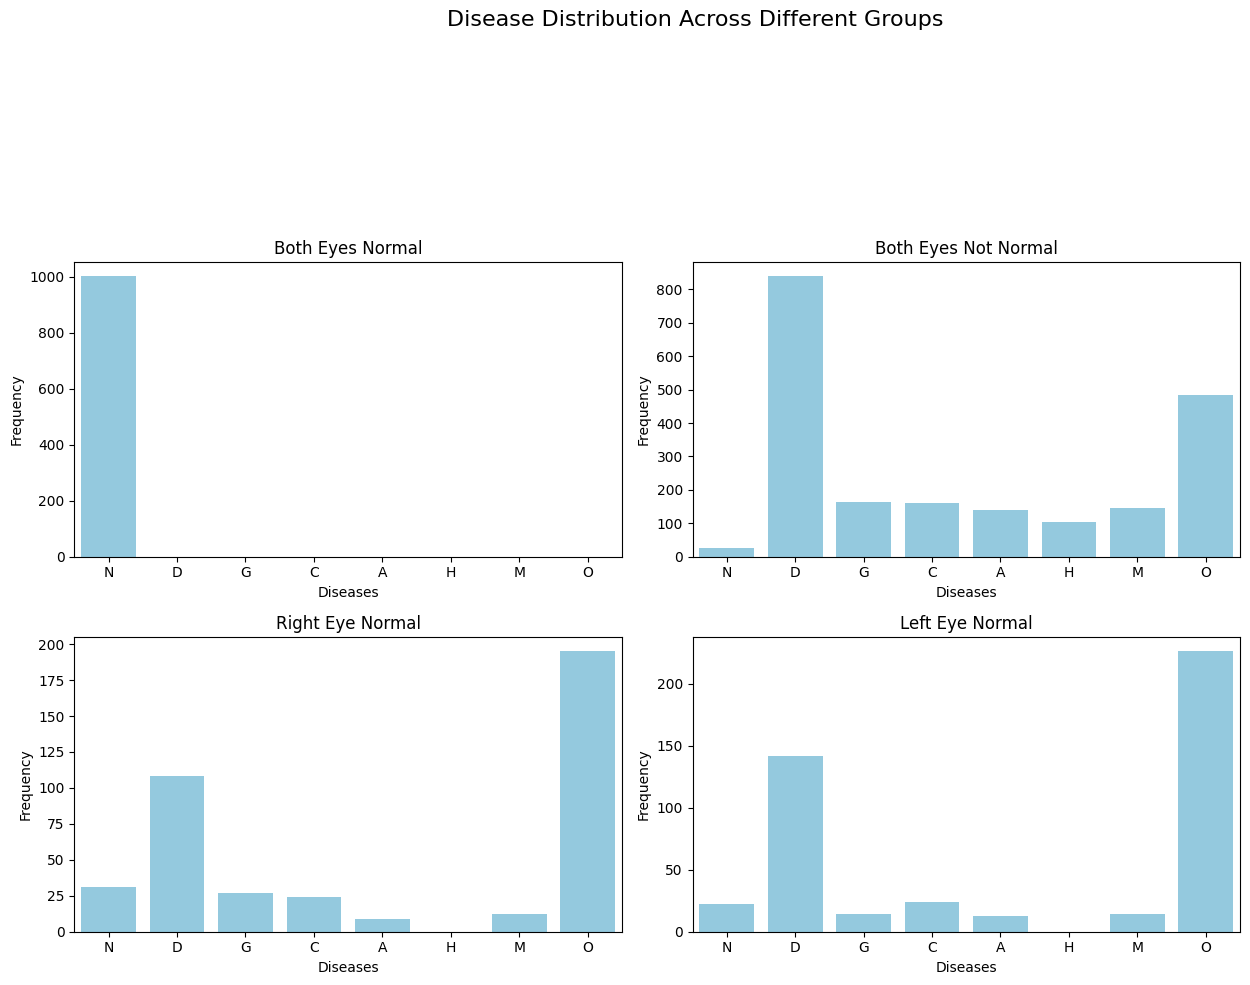

In [462]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]

# Loop through DataFrames and plot on subplots
for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()
    
    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, .9, 0.80])
plt.show()

In [463]:
len(both_eyes_normal)

1001

In [464]:
both_eyes_not_normal[both_eyes_not_normal['N'] == 1]

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
987,70,Female,2357_left.jpg,2357_right.jpg,normal fundus，lens dust,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2357_right.jpg
988,70,Female,2571_left.jpg,2571_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2571_right.jpg
989,59,Male,2580_left.jpg,2580_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2580_right.jpg
990,45,Male,2589_left.jpg,2589_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2589_right.jpg
991,67,Male,2598_left.jpg,2598_right.jpg,normal fundus，lens dust,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2598_right.jpg
992,70,Female,2611_left.jpg,2611_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2611_right.jpg
993,67,Female,2719_left.jpg,2719_right.jpg,normal fundus，lens dust,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2719_right.jpg
994,43,Male,2752_left.jpg,2752_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2752_right.jpg
995,62,Female,2893_left.jpg,2893_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2893_right.jpg
996,66,Female,2959_left.jpg,2959_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2959_right.jpg


In [465]:
len(both_eyes_not_normal[both_eyes_not_normal['N'] == 1])

25

In [466]:
filtered_df = both_eyes_not_normal[both_eyes_not_normal['N'] == 1]
both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [467]:
len(both_eyes_normal)

1026

In [468]:
both_eyes_not_normal = both_eyes_not_normal.loc[(both_eyes_not_normal['N'] != 1)]

In [469]:
both_eyes_not_normal.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
1,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
2,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
3,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
4,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg


In [470]:
right_eye_normal[right_eye_normal['N'] == 1]

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
269,68,Male,2400_left.jpg,2400_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2400_right.jpg
270,33,Male,2483_left.jpg,2483_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2483_right.jpg
271,50,Female,2486_left.jpg,2486_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2486_right.jpg
272,68,Female,2495_left.jpg,2495_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2495_right.jpg
273,52,Female,2496_left.jpg,2496_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2496_right.jpg
274,72,Female,2509_left.jpg,2509_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2509_right.jpg
275,62,Female,2566_left.jpg,2566_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2566_right.jpg
276,34,Male,2629_left.jpg,2629_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2629_right.jpg
277,49,Female,2652_left.jpg,2652_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2652_right.jpg
278,45,Female,2661_left.jpg,2661_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2661_right.jpg


In [471]:
filtered_df = right_eye_normal[right_eye_normal['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()                         

In [472]:
right_eye_normal = right_eye_normal.loc[~(right_eye_normal['N'] == 1)]

In [473]:
left_eye_normal[left_eye_normal['N'] == 1]

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
241,46,Female,2370_left.jpg,2370_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2370_right.jpg
242,69,Male,2520_left.jpg,2520_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2520_right.jpg
243,51,Male,2954_left.jpg,2954_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2954_right.jpg
244,63,Female,3283_left.jpg,3283_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",3283_right.jpg
412,51,Male,2377_left.jpg,2377_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2377_left.jpg
413,56,Male,2448_left.jpg,2448_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2448_left.jpg
414,39,Male,2515_left.jpg,2515_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2515_left.jpg
415,75,Male,2724_left.jpg,2724_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2724_left.jpg
416,66,Male,2727_left.jpg,2727_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2727_left.jpg
417,62,Female,2729_left.jpg,2729_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2729_left.jpg


In [474]:
filtered_df = left_eye_normal[left_eye_normal['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [475]:
left_eye_normal = left_eye_normal.loc[(left_eye_normal['N'] != 1)]

In [476]:
len(both_eyes_normal)

1079

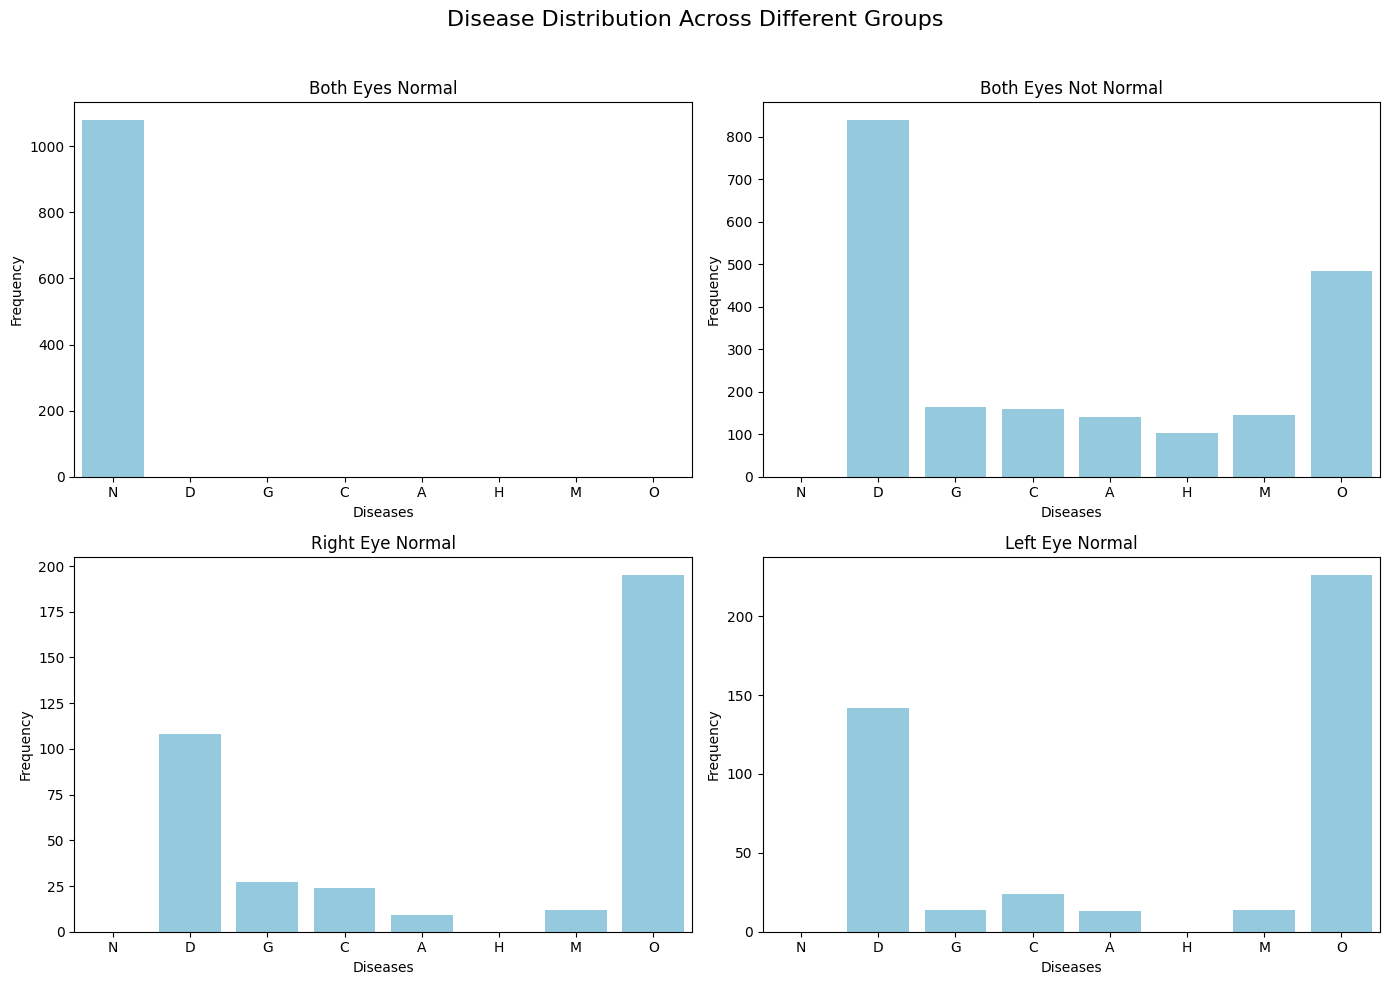

In [477]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]

# Loop through DataFrames and plot on subplots
for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()
    
    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [478]:
left_eye_normal.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,O,"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
1,55,Male,14_left.jpg,14_right.jpg,normal fundus,macular epiretinal membrane,0,0,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,O,"[0, 0, 0, 0, 0, 0, 0, 1]",14_right.jpg
2,50,Male,15_left.jpg,15_right.jpg,normal fundus,myelinated nerve fibers,0,0,0,0,0,0,0,1,eye_disease_detection_dataset/archive/ODIR-5K/...,O,"[0, 0, 0, 0, 0, 0, 0, 1]",15_right.jpg
3,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,eye_disease_detection_dataset/archive/ODIR-5K/...,M,"[0, 0, 0, 0, 0, 0, 1, 0]",16_right.jpg
4,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,eye_disease_detection_dataset/archive/ODIR-5K/...,C,"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg


In [479]:
df= pd.concat([both_eyes_normal,both_eyes_not_normal,left_eye_normal,right_eye_normal],ignore_index=True)

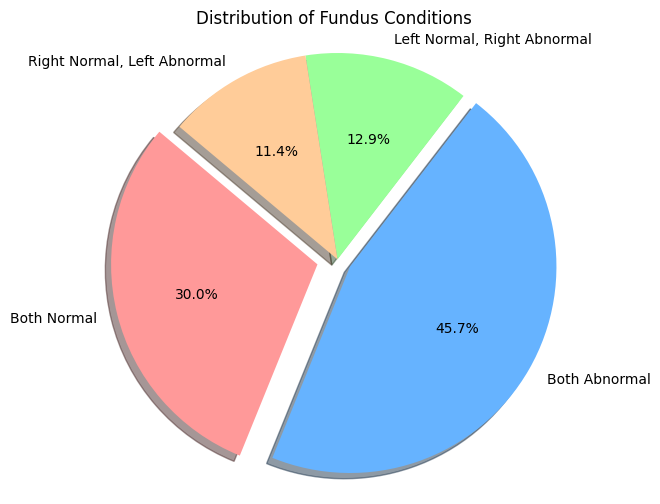

In [480]:
condition_normal_left = df['Left-Diagnostic Keywords'] == 'normal fundus'
condition_normal_right = df['Right-Diagnostic Keywords'] == 'normal fundus'

# Determine the categories
both_normal = (condition_normal_left) & (condition_normal_right)
both_abnormal = (~condition_normal_left) & (~condition_normal_right)
left_normal_right_abnormal = (condition_normal_left) & (~condition_normal_right)
right_normal_left_abnormal = (~condition_normal_left) & (condition_normal_right)

# Count occurrences for each category
counts = {
    'Both Normal': both_normal.sum(),
    'Both Abnormal': both_abnormal.sum(),
    'Left Normal, Right Abnormal': left_normal_right_abnormal.sum(),
    'Right Normal, Left Abnormal': right_normal_left_abnormal.sum()
}

# Create a pie chart
labels = counts.keys()
sizes = counts.values()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.1, 0.07, 0, 0)  # explode the 1st slice (optional)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Fundus Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()




In [481]:
df['labels'].unique()

array(['N', 'DO', 'D', 'DH', 'M', 'O', 'H', 'GA', 'DM', 'A', 'DA', 'DC',
       'GH', 'CO', 'AO', 'G', 'DCO', 'DHO', 'AH', 'HO', 'CH', 'C', 'GCO',
       'DG', 'DAM', 'MO', 'GO', 'GM', 'GHO', 'DGO', 'GC', 'DMO', 'DGM',
       'DAO', 'AM', 'GMO', 'GAO'], dtype=object)

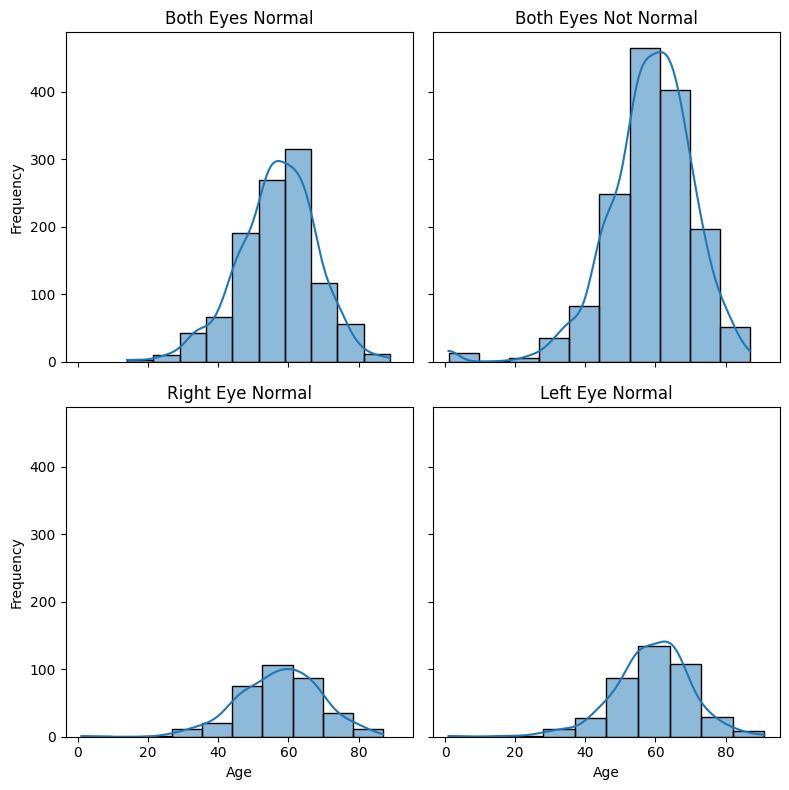

In [482]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

# List of dataframes and titles
dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]
titles = ['Both Eyes Normal', 'Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']

# Plot each dataframe
for i, (eye, title) in enumerate(zip(dataframes, titles)):
    row = i // 2
    col = i % 2
    sns.histplot(eye['Patient Age'], kde=True, bins=10, ax=axes[row, col])
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('Age')
    axes[row, col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [483]:
df['labels'].unique()

array(['N', 'DO', 'D', 'DH', 'M', 'O', 'H', 'GA', 'DM', 'A', 'DA', 'DC',
       'GH', 'CO', 'AO', 'G', 'DCO', 'DHO', 'AH', 'HO', 'CH', 'C', 'GCO',
       'DG', 'DAM', 'MO', 'GO', 'GM', 'GHO', 'DGO', 'GC', 'DMO', 'DGM',
       'DAO', 'AM', 'GMO', 'GAO'], dtype=object)

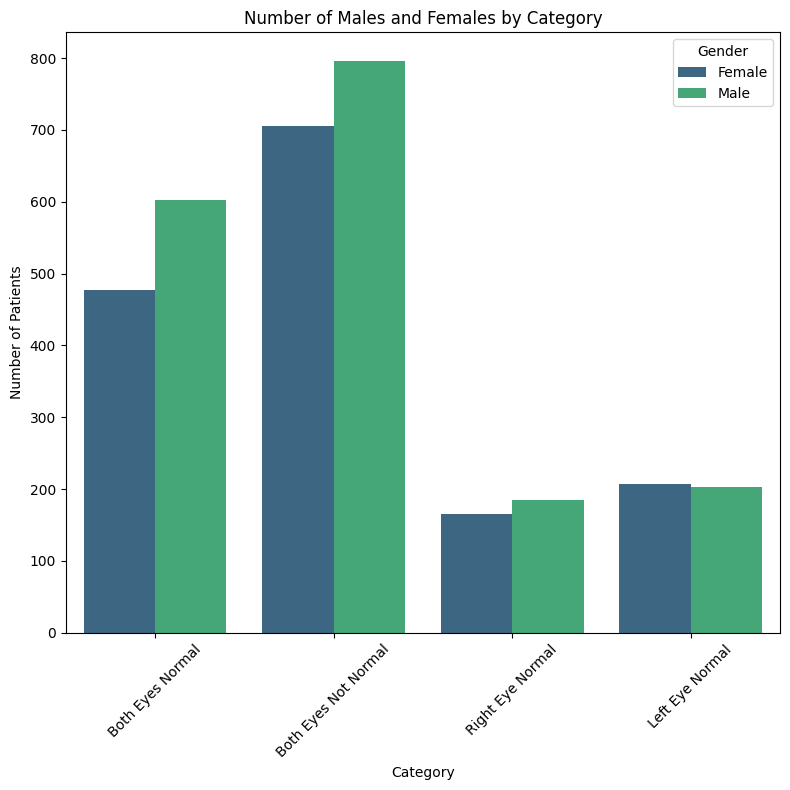

In [484]:
counts = {
    'Both Eyes Normal': both_eyes_normal['Patient Sex'].value_counts(),
    'Both Eyes Not Normal': both_eyes_not_normal['Patient Sex'].value_counts(),
    'Right Eye Normal': right_eye_normal['Patient Sex'].value_counts(),
    'Left Eye Normal': left_eye_normal['Patient Sex'].value_counts()
}

# Convert to DataFrame for easy plotting
plot_data = pd.DataFrame(counts).fillna(0).T.reset_index()
plot_data = plot_data.melt(id_vars='index', var_name='Gender', value_name='Count')
plot_data = plot_data.rename(columns={'index': 'Category'})

# Create the bar plot
plt.figure(figsize=(8, 8))
sns.barplot(data=plot_data, x='Category', y='Count', hue='Gender', palette='viridis')

plt.title('Number of Males and Females by Category')
plt.xlabel('Category')
plt.ylabel('Number of Patients')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

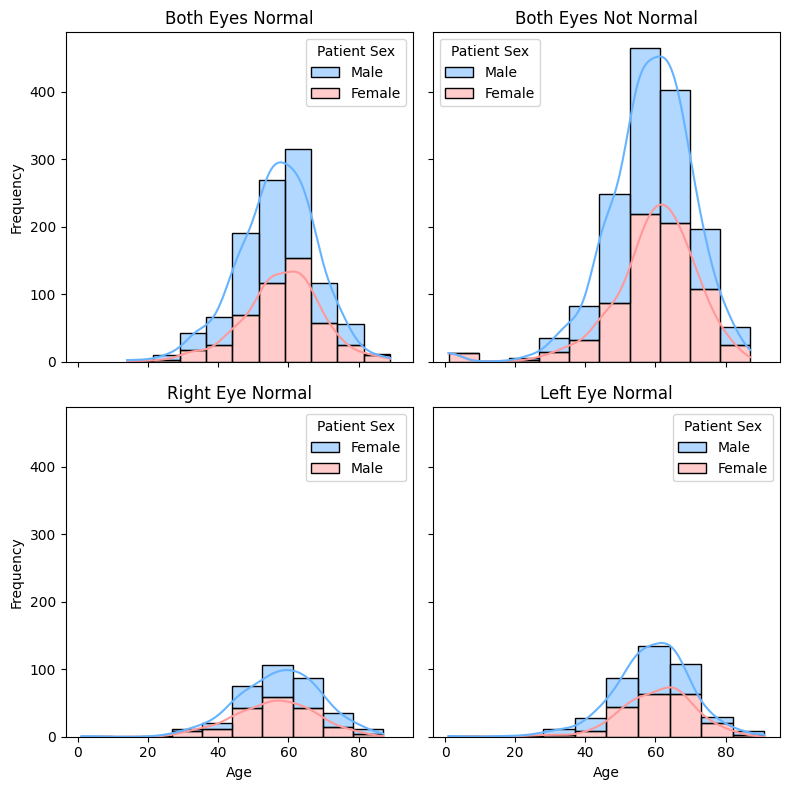

In [485]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]
titles = ['Both Eyes Normal', 'Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']
colors = ['#66b3ff', '#ff9999']

# Plot each dataframe
for i, (eyes, title) in enumerate(zip(dataframes, titles)):
    row = i // 2
    col = i % 2
    sns.histplot(eyes, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=axes[row, col], kde=True)
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('Age')
    axes[row, col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [486]:
df['labels'].unique()

array(['N', 'DO', 'D', 'DH', 'M', 'O', 'H', 'GA', 'DM', 'A', 'DA', 'DC',
       'GH', 'CO', 'AO', 'G', 'DCO', 'DHO', 'AH', 'HO', 'CH', 'C', 'GCO',
       'DG', 'DAM', 'MO', 'GO', 'GM', 'GHO', 'DGO', 'GC', 'DMO', 'DGM',
       'DAO', 'AM', 'GMO', 'GAO'], dtype=object)

In [487]:
cluster_features = ['Patient Age', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
X_cluster = df[cluster_features].copy()

# Convert Patient Sex to numeric
X_cluster['Patient_Sex_Numeric'] = df['Patient Sex'].map({'Male': 0, 'Female': 1})

# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

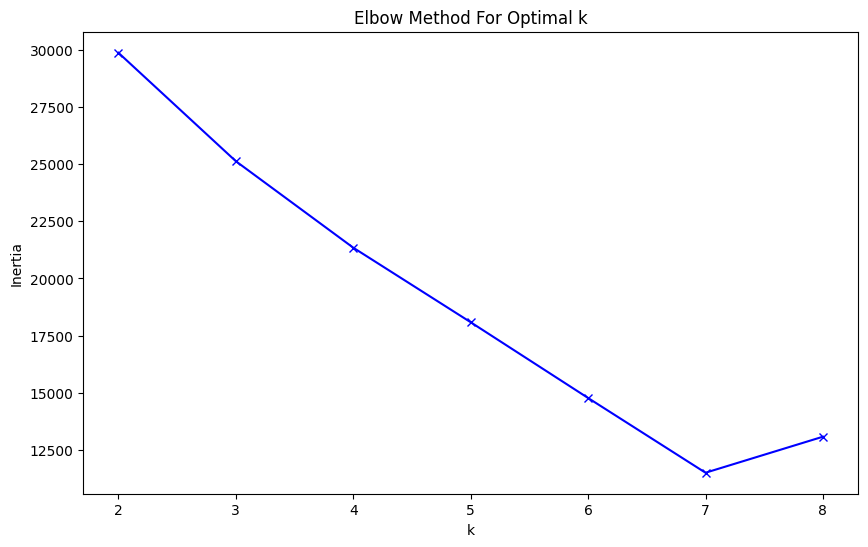

In [ ]:
# Perform K-means clustering
inertias = []
k_range = range(2, 9)
for k in k_range:
   kmeans = KMeans(n_clusters=k, random_state=42)
   kmeans.fit(X_scaled)
   inertias.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [489]:
# Train final model with optimal k
n_clusters = 7  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled) #Compute cluster centers and predict cluster index for each sample.

# Add cluster labels to the dataframe
df['Cluster'] = clusters

print("Cluster distribution:")
print(df['Cluster'].value_counts())

Cluster distribution:
Cluster
1    1448
2    1079
3     205
4     178
6     168
0     159
5     103
Name: count, dtype: int64


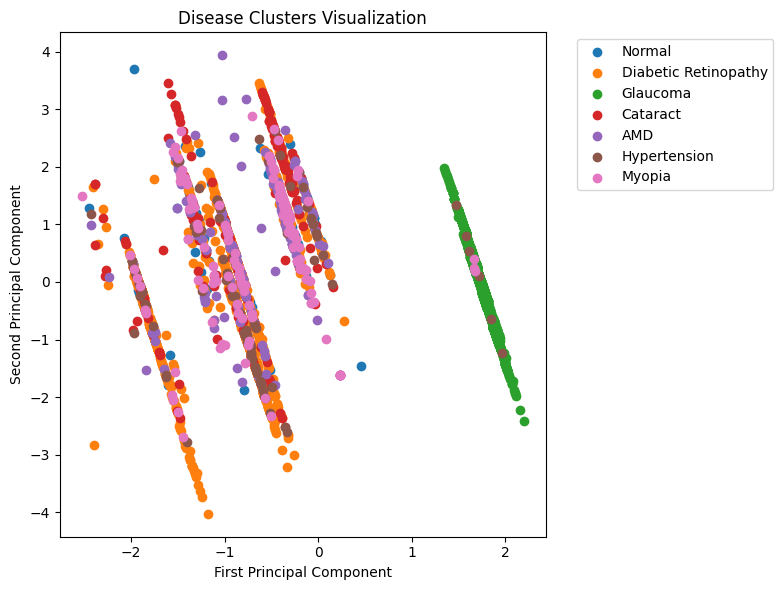

In [ ]:
# Plotting cluster visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# First ensure X_scaled and clusters have same length
X_scaled = X_scaled[:min(len(X_scaled), len(clusters))]
clusters = clusters[:min(len(X_scaled), len(clusters))]

# Now apply PCA(Principle component Analysis) and plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Define feature names for plotting
cluster_features = ['Normal', 'Diabetic Retinopathy', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia']

plt.figure(figsize=(8,6))
for i in range(7):
   mask = clusters == i
   plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=cluster_features[i])

plt.title('Disease Clusters Visualization')
plt.xlabel('First Principal Component') 
plt.ylabel('Second Principal Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

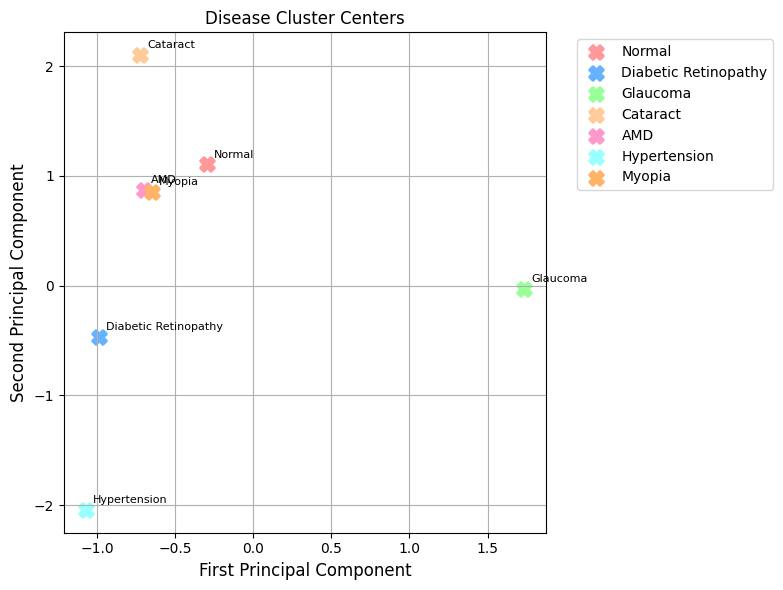

In [432]:
plt.figure(figsize=(8,6))

# Define colors for each cluster
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99FFFF', '#FFB366']

# Plot cluster centers with different colors
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)
for i, (x, y) in enumerate(cluster_centers_pca):
   plt.scatter(x, y, 
               c=colors[i], 
               marker='X', 
               s=100,
               linewidths=2,
               label=cluster_features[i])
   
   # Add labels
   plt.annotate(cluster_features[i], 
               (x, y),
               xytext=(5, 5),
               textcoords='offset points',
               fontsize=8)

plt.title('Disease Cluster Centers', fontsize=12)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Preparing data
IMG_SIZE = 128

def prepare_data(df):
    X = []
    y = []
    cluster_info = []
    base_path = 'eye_disease_detection_dataset/archive/preprocessed_images/'
    
    print("Starting data preparation...")
    total = len(df)
    
    # Progress indicator
    for idx, row in df.iterrows():
        if idx % 100 == 0:  
            print(f"Processing {idx}/{total} images")
            
        img_path = os.path.join(base_path, row['Right-Fundus'])
        try:
            # Check if file exists
            if not os.path.exists(img_path):
                print(f"File not found: {img_path}")
                continue
                
            # Load and process image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
                
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0
            
            # Create label array
            label = np.array([row['N'], row['D'], row['G'], row['C'], 
                            row['A'], row['H'], row['M'], row['O']])
            
            # Append data
            X.append(img)
            y.append(label)
            cluster_info.append(row['Cluster'])
            
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            continue
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    cluster_info = np.array(cluster_info)
    
    print("\nFinal data shapes:")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"clusters shape: {cluster_info.shape}")
    
    return X, y, cluster_info

# Verify df has Cluster column
if 'Cluster' not in df.columns:
    print("Error: 'Cluster' column not found in dataframe")
    print("Available columns:", df.columns.tolist())
else:
    # Prepare the data
    X, y, clusters = prepare_data(df)

Starting data preparation...
Processing 0/3340 images
Processing 100/3340 images
Processing 200/3340 images
Processing 300/3340 images
Processing 400/3340 images
Processing 500/3340 images
Processing 600/3340 images
Processing 700/3340 images
Processing 800/3340 images
Processing 900/3340 images
Processing 1000/3340 images
File not found: eye_disease_detection_dataset/archive/preprocessed_images/2350_right.jpg
File not found: eye_disease_detection_dataset/archive/preprocessed_images/2428_right.jpg
File not found: eye_disease_detection_dataset/archive/preprocessed_images/2477_right.jpg
File not found: eye_disease_detection_dataset/archive/preprocessed_images/2478_right.jpg
File not found: eye_disease_detection_dataset/archive/preprocessed_images/2516_right.jpg
File not found: eye_disease_detection_dataset/archive/preprocessed_images/2546_right.jpg
File not found: eye_disease_detection_dataset/archive/preprocessed_images/2664_right.jpg
File not found: eye_disease_detection_dataset/archiv

In [384]:
# Cell 3: Verify data before splitting
print("\nVerification before splitting:")
print("X type:", type(X))
print("y type:", type(y))
print("clusters type:", type(clusters))
print("\nX shape:", X.shape)
print("y shape:", y.shape)
print("clusters shape:", clusters.shape)
print("\nUnique clusters:", np.unique(clusters))


Verification before splitting:
X type: <class 'numpy.ndarray'>
y type: <class 'numpy.ndarray'>
clusters type: <class 'numpy.ndarray'>

X shape: (3187, 128, 128, 3)
y shape: (3187, 8)
clusters shape: (3187,)

Unique clusters: [0 1 2 3 4 5 6]


In [385]:
# Cell 3: Split the data
X_train, X_test, y_train, y_test, clusters_train, clusters_test = train_test_split(
    X, y, clusters,
    test_size=0.2,
    random_state=42,
    stratify=clusters
)
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("clusters_train:", clusters_train.shape)

Training set shapes:
X_train: (2549, 128, 128, 3)
y_train: (2549, 8)
clusters_train: (2549,)


In [ ]:
# Create a CNN model
def create_robust_model(input_shape, num_clusters, num_classes):
    # Image input branch
    img_input = Input(shape=input_shape)
    
    # First Convolutional Block
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second Convolutional Block
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Third Convolutional Block
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Global Average Pooling instead of Flatten
    x = GlobalAveragePooling2D()(x)
    
    # Cluster input branch
    cluster_input = Input(shape=(1,))
    cluster_encoded = Dense(32, activation='relu')(cluster_input)
    cluster_encoded = BatchNormalization()(cluster_encoded)
    
    # Combine image features and cluster information
    combined = Concatenate()([x, cluster_encoded])
    
    # Dense layers
    x = Dense(256, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    output = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=[img_input, cluster_input], outputs=output)

In [387]:
# Cell 3: Create and compile model
IMG_SIZE = 128  # Increased image size
n_clusters = 3

model = create_robust_model(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_clusters=n_clusters,
    num_classes=8
)

# Compile with better optimizer settings
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 64, 64,    │          0 │ max_pooling2d_15… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │     18,496 │ dropout_25[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 32, 32,    │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │     73,856 │ dropout_26[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_35[0][0] 

 Total params: 365,672 (1.39 MB)

 Trainable params: 363,944 (1.39 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [388]:
history = model.fit(
    [X_train, clusters_train],
    y_train,
    batch_size=32,
    epochs=20,  # Reduced epochs since we don't have early stopping
    validation_data=([X_test, clusters_test], y_test),
    verbose=1
)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 413ms/step - accuracy: 0.2590 - loss: 3.0103 - val_accuracy: 0.3621 - val_loss: 2.1689
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 422ms/step - accuracy: 0.5729 - loss: 1.9347 - val_accuracy: 0.4060 - val_loss: 1.6761
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 447ms/step - accuracy: 0.6208 - loss: 1.7059 - val_accuracy: 0.6599 - val_loss: 1.1368
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 444ms/step - accuracy: 0.6220 - loss: 1.4936 - val_accuracy: 0.6944 - val_loss: 1.0204
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 447ms/step - accuracy: 0.6631 - loss: 1.3301 - val_accuracy: 0.6661 - val_loss: 0.9353
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step - accuracy: 0.6547 - loss: 1.3232 - val_accuracy: 0.7414 - val_loss: 0.9603
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 447ms/step - accuracy: 0.6736 - loss: 1.1987 - val_accuracy: 0.7806 - val_loss: 0.9971
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 447ms/step - accuracy: 0.6652 - loss: 1.2068 - val_accu

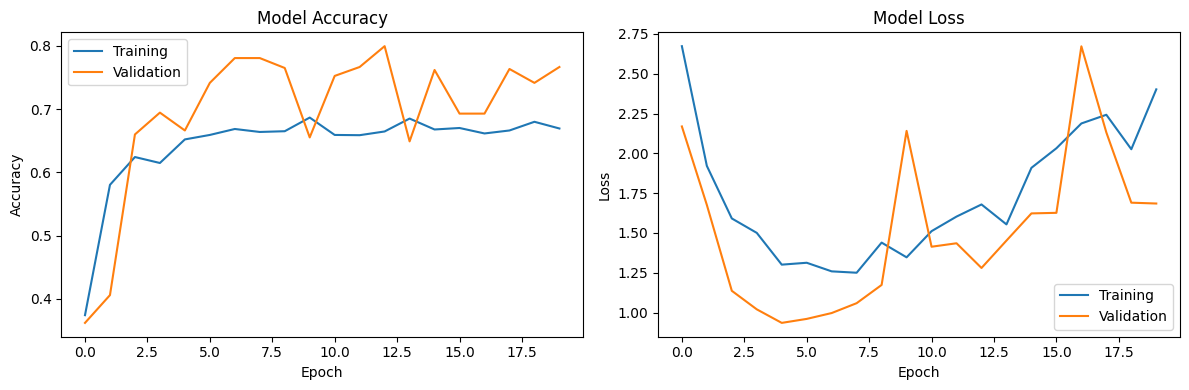

In [ ]:
# Visualize results
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       210
    Diabetes       0.60      0.91      0.73       205
    Glaucoma       0.00      0.00      0.00        34
    Cataract       0.85      1.00      0.92        35
         AMD       0.84      0.93      0.88        28
Hypertension       0.40      1.00      0.57         8
      Myopia       0.90      1.00      0.95        28
       Other       0.00      0.00      0.00        90

    accuracy                           0.77       638
   macro avg       0.57      0.73      0.63       638
weighted avg       0.65      0.77      0.70       638



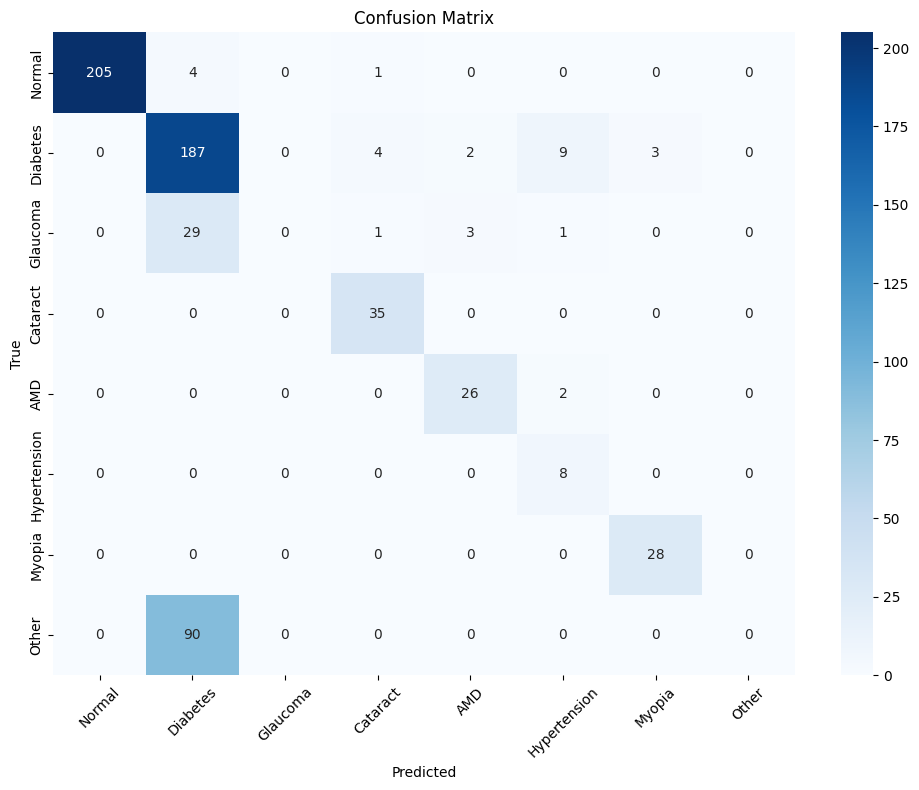


Detailed Metrics for Normal:
Precision: 1.000
Recall: 0.976
F1-Score: 0.988

Detailed Metrics for Diabetes:
Precision: 0.603
Recall: 0.912
F1-Score: 0.726

Detailed Metrics for Glaucoma:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000

Detailed Metrics for Cataract:
Precision: 0.854
Recall: 1.000
F1-Score: 0.921

Detailed Metrics for AMD:
Precision: 0.839
Recall: 0.929
F1-Score: 0.881

Detailed Metrics for Hypertension:
Precision: 0.400
Recall: 1.000
F1-Score: 0.571

Detailed Metrics for Myopia:
Precision: 0.903
Recall: 1.000
F1-Score: 0.949

Detailed Metrics for Other:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000


In [ ]:
# Get model predictions
y_pred = model.predict([X_test, clusters_test])

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define class names for better readability
class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 
               'AMD', 'Hypertension', 'Myopia', 'Other']

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate additional metrics per class
for i, class_name in enumerate(class_names):
    true_class = (y_test_classes == i)
    pred_class = (y_pred_classes == i)
    
    # Calculate True Positives, False Positives, False Negatives
    tp = np.sum(true_class & pred_class)
    fp = np.sum(~true_class & pred_class)
    fn = np.sum(true_class & ~pred_class)
    
    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nDetailed Metrics for {class_name}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")